<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 25px; color: #3498db">1- <u>reduction du nombre de variable de base_edu </u></h1>
    

In [ ]:
!pip install fastparquet
!pip install rpy2
!pip install pandas
!pip install matplotlib

In [3]:
#importation des packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
#chemin de la Base de données; 
#commentez l'url et vous remplacez par votre chemin sans supprimer!!!!!

url="C:/Users/lisaw/Desktop/ENSAE/2AD/Projet-stat-ap/Donnees/base_Edu.parquet"
base_Edu=pd.read_parquet(url)
base_Edu.head()

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0


In [5]:
print(base_Edu.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [5]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [6]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [7]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [8]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [9]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [10]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [11]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [13]:
base_Edu.isnull().any().sum()

0

In [12]:
df1 = base_Edu.select_dtypes(exclude=['datetime64'])  # Colonnes non datetime64
df2 = base_Edu.select_dtypes(include=['datetime64']) #colonnes datetime
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 372 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(47), category(254), float64(71)
memory usage: 237.5 MB


In [13]:
#sauvegarde des données sans var date
df1.to_parquet('data_Edu.parquet', index=False)

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;color:rgb(47, 99, 220);font-size: 30px">
<u>
Réduction de dimension</u>
</p>
<br/>

Etant donnée la dimension de la base de données( beaucoup de variables), ce sera très complexe voir impossible de faire des analyses ou entrainer un modèle directement sur cette base. Il est donc important voir optimale de faire au préalable une réduction de dimension. Pour ce faire, nous allons utiliser différentes approches de réduction de dimension, faire des comparaisons puis retenir la meilleure approche dans ce cas. Il s'agira principalement de faire une **analyse enn composante principale (ACP)** , une **FAMD** et utiliser **un autoencodeur**.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
1- Analyse en composantes principales (ACP) </u>
</p>
<br/>

Pour effectuer l'ACP il faut restreindre la base aux variables quantitatives.

In [14]:
data=base_Edu.select_dtypes(include=["int","float"])
data=data.drop(["unique_learner_id"], axis=1)

Par la suite, nous allons standardiser les variables afin de faire qu'elles aient toutes la même échelle car l'ACP dépend fortement de l'échelle des variables.

In [15]:
scaler =StandardScaler()
X_scaled =scaler.fit_transform(data)

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
 a)- Choix du nombre de composantes principales
</p>
<br/>

#### **Règle du coude**

Il s'agit ici de construire la courbe de décroissance des valeurs propres et de détecter des "coudes" (ou "cassures") signalant un changement de structure.

Text(0.5, 0, 'Principal components')

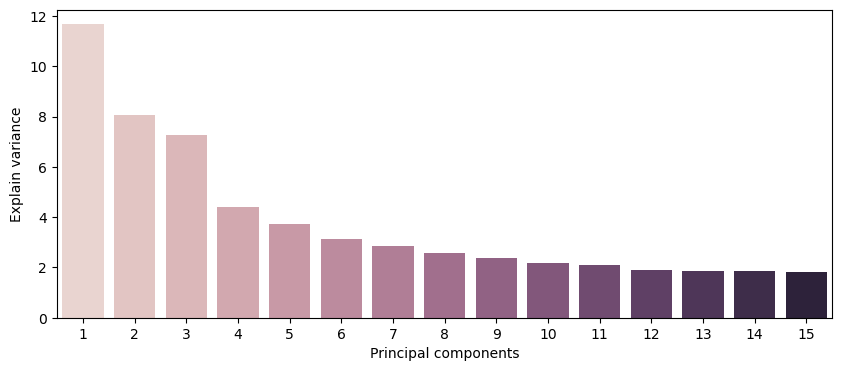

In [25]:
plt.figure(figsize=(10, 4))
pca=PCA(n_components=15)
pca.fit(X_scaled)
sns.barplot(x= np.arange(1,16) , y=pca.explained_variance_ratio_*100, hue=np.arange(1,16), legend=False)
plt.ylabel("Explain variance")
plt.xlabel("Principal components")

On observe de ce graphique qu'il y a deux coudes possibles, l'un à la deuxième composante et l'autre à la sixième composante. La première composante principale explique 11,66% de la variance totale, la deuxième en explique 8,05%, la troisième 7,27%, et à partir de la sixième composante principale, le pourcentage de variable expliquée devient inférieur à 3%. Les facteurs restants ont donc un apport d'information négligeable.

A ce graphique, on ajoute le graphique qui décrit l'évolution de la variance expliquée par les axes.

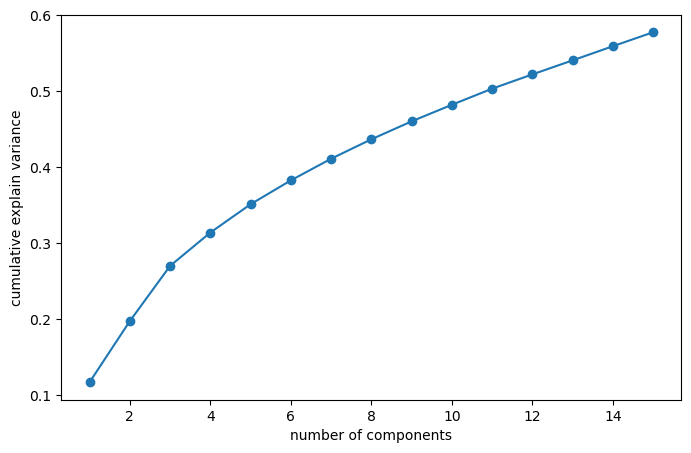

In [26]:
explained_variances=[]
for n in range(1,16):
    pca =PCA(n_components=n)
    pca.fit(X_scaled)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,5))
plt.plot(range(1,16), explained_variances, marker='o')
plt.xlabel("number of components")
plt.ylabel("cumulative explain variance")
plt.show()

Ce graphique semble indiquer que le coude se trouve à la troisième composante principale. Cependant, Considerer trois composantes principales n'est pas une bonne idée car on perdrais le gain d'information substanciel qu'apporte les 2 composantes principales suivantes. Les 5 premières composantes principales expliquent environ 35% de l'information. Nous allons poursuivre cette recherche du nombre de composantes optimale en utilisant le test des bâtons brisés.

#### **Test des « bâtons brisés »**

Ce test est du à Frontier (1976) et Legendre-Legendre (1983). Il repose sur l’idée que si l’inertie totale était dispatchée aléatoirement sur les axes, la distribution des valeurs propres suivrait la loi des 
« bâtons brisés » (broken-stick). La valeur critique pour le choix des composantes principales s'écrit comme suit:
$$ b_{k} = \sum_{i=k}^{p} \frac 1 {i}$$

où p représente le nombre de variables.

In [23]:
baton_coef=[]
for i in np.arange(1,16):
    n=0
    for j in range(i,117):
        n=n+(1/j)
    baton_coef.append(n)

In [24]:
data1=pd.DataFrame(data=pca.explained_variance_, columns=["eigen_values"])
data1["b_k"]=baton_coef
data1.index=["PC{}".format(i) for i in np.arange(1,16)]
data1

,eigen_values,b_k
PC1,11.433010,5.335110
PC2,7.889850,4.335110
PC3,7.125282,3.835110
PC4,4.303626,3.501777
PC5,3.656622,3.251777
PC6,3.079037,3.051777
PC7,2.792477,2.885110
PC8,2.509312,2.742253
PC9,2.315227,2.617253
PC10,2.138628,2.506142


Avec ce test on peut retenir 5 composantes principales, car à la différence entre la valeur propre de la sixième composante principale et le seuil calculé est négligeable. Pour les composantes suivantes, les valeurs propres sont en dessous du seuil.

Nous retiendrons donc 5 composantes principales dans la suite.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
b)- Entrainement du modèle
</p>
<br/>

In [16]:
# training the model with 5 principal components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("Explain variance for each component :",pca.explained_variance_ratio_)
print("cumulated variance :",pca.explained_variance_ratio_.sum())

Explain variance for each component : [0.11666279 0.08050827 0.0727066  0.04391469 0.03731249]
cumulated variance : 0.3511048318033728


In [17]:
# coefficients of the principal components 
print("Composantes principales (coefficients) :")
table_coef=pd.DataFrame(pca.components_, columns=data.select_dtypes(exclude='category').columns)
table_coef.index=["PC{}".format(i+1) for i in np.arange(0,5)]
table_coef

Composantes principales (coefficients) :


,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,percentage_activities_2_3_4h_week,percentage_activities_5_6_7h_week,percentage_activities_23_0_1h_week,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
PC1,0.066023,0.075380,-0.004304,-2.710505e-20,0.117614,0.108084,0.151237,-0.005015,0.010848,0.006412,...,0.124556,0.124960,0.125143,0.096558,0.017135,-0.004208,0.089261,0.075793,0.014699,-0.085941
PC2,-0.008063,-0.011526,0.001866,0.000000e+00,0.064442,0.019719,0.024426,0.005472,-0.002838,0.010553,...,0.309994,0.305893,0.300151,0.033900,0.009572,0.012058,0.210167,-0.048971,0.004086,0.027052
PC3,-0.011089,-0.024572,0.029455,-1.110223e-16,-0.054100,0.053615,-0.048470,0.009290,-0.005749,0.014140,...,0.038576,0.037714,0.036979,0.021819,0.007797,-0.092366,0.025101,0.109215,0.007513,-0.111341
PC4,-0.012169,-0.023764,-0.102450,-5.551115e-17,-0.172160,-0.000519,-0.288067,-0.011698,-0.003291,-0.014431,...,0.053974,0.051357,0.047793,-0.081462,-0.001142,-0.133473,0.050539,0.034535,0.001306,-0.039158
PC5,0.096430,0.049827,0.418300,0.000000e+00,0.002723,-0.017382,0.017505,0.011653,0.012641,0.005018,...,-0.000583,-0.000302,0.000038,0.023226,0.006160,0.019295,-0.008328,0.023598,0.004648,-0.022514


In [18]:
# contributions of the principal components
loadings=pca.components_.T
eigenvalues=pca.explained_variance_
contributions=(loadings**2)*eigenvalues
contrib_percent=contributions/(eigenvalues.sum())*100
contrib_df=pd.DataFrame(contrib_percent, columns=["PC{}".format(i+1) for i in np.arange(0,5)])
contrib_df.index=data.columns
contrib_df.head()

,PC1,PC2,PC3,PC4,PC5
days_between_signup_and_first_activity,1.448413e-01,0.001491,2.546388e-03,1.852225e-03,0.098820
days_between_order_and_first_activity,1.888035e-01,0.003046,1.250339e-02,7.063180e-03,0.026384
days_between_first_and_last_activities,6.153829e-04,0.000080,1.796671e-02,1.312800e-01,1.859487
chapter_before_success_count,2.441159e-38,0.000000,2.552451e-31,3.854193e-32,0.000000
serie_before_success_count,4.596384e-01,0.095224,6.060847e-02,3.707144e-01,0.000079


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
c)- Interprétaion des axes principaux
</p>
<br/>

Seront considérées comme variables les plus contributrices à la formation d'un axe principale, les variables dont la contribution est supérieur à la contribution moyenne, c'est-à-dire: $$ 100/117 \approx 0.855 $$  

In [33]:
contrib1=pd.DataFrame(data=contrib_df["PC1"].sort_values(ascending=False)[:16].values, columns=["contribution"]) 
contrib1.index=contrib_df["PC1"].sort_values(ascending=False)[:16].index
contrib1["coefficient"]=table_coef[contrib1.index].iloc[0]
contrib1

,contribution,coefficient
notions_diverses_number_of_activities,1.464529,0.209943
mecanique_equipements_number_of_activities,1.421391,0.206828
prendre_quitter_vehicule_number_of_activities,1.404160,0.205570
autres_usagers_number_of_activities,1.403937,0.205554
route_number_of_activities,1.382899,0.204008
securite_number_of_activities,1.377518,0.203611
premiers_secours_number_of_activities,1.370145,0.203065
environnement_number_of_activities,1.323408,0.199572
conducteur_number_of_activities,1.258079,0.194584
score_pct__quantile__q_0_4,1.089173,0.181051


Les variables qui contribuent le plus à la construction de la première composante principale sont des variables qui renseigne sur le nombre d'activité effectuer par thématique pour le permis de conduire (*notions_diverses_number_of_activities*, *mecanique_equipements_number_of_activities*,*securite_number_of_activities*, *route_number_of_activities*, *prendre_quitter_vehicule_number_of_activities*, *autres_usagers_number_of_activities*,etc.) et les statistiques qui résultent des scores en pourcentage obtenus aux différents examens notamment les quantiles d'ordre 1, 2, 3 et 4 (*score_pct__quantile__q_0_1*, *score_pct__quantile__q_0_2*, *score_pct__quantile__q_0_3*, *score_pct__quantile__q_0_4*), et .... Cet axe résume le signal et/ou la corrélation qui existe entre le nombre d'activités effectués par thématique et la distribution du score au différents examens. On pourrait donc dire qu'il traduit l'**efficacité** des étudiants.

De plus, en analysant les coefficients de ces variables, ont constate qu'elles sont toutes positifs. Ainsi, un individu ayant un coefficient élevé sur cet axe, fait beaucoup d'activité sur les différentes thématiques d'apprentissage et a des scores élevés aux différents examens, ce qui signifie qu'il comprend bien ce qu'il fait.

In [34]:
contrib2=pd.DataFrame(data=contrib_df["PC2"].sort_values(ascending=False)[:9].values, columns=["contribution"]) 
contrib2.index=contrib_df["PC2"].sort_values(ascending=False)[:9].index
contrib2["coefficient"]=table_coef[contrib2.index].iloc[1]
contrib2

,contribution,coefficient
nb_weeks_weekly_study_objective_reached_90pct,2.248430,0.313139
nb_weeks_weekly_study_objective_reached_85pct,2.236727,0.312323
nb_weeks_weekly_study_objective_reached_95pct,2.236287,0.312293
nb_weeks_weekly_study_objective_reached_99pct,2.216164,0.310884
nb_weeks_weekly_study_objective_reached,2.208697,0.310360
nb_weeks_weekly_study_objective_reached_80pct,2.203486,0.309994
nb_weeks_weekly_study_objective_reached_75pct,2.145577,0.305893
nb_weeks_weekly_study_objective_reached_70pct,2.065778,0.300151
pct_study_objective_reached,1.012819,0.210167


Les variables qui contribuent fortement à la deuxième composante principale sont d'une part les variables qui renseignent sur le nombre de week-end où les objectifs d'étude hebdomadaire ont atteint un pourcentage donnée (90%,85%,95%,99%,75%,etc) et d'autre part les variables qui donnent le pourcentage d'objectifs d'études atteint le week-end (*nb_weeks_weekly_study_objective_reached*) et en dehors (*pct_study_objective_reached*). On pourrait dire que cet axe capture principalement l'information sur **l'intensité du travail personnel des étudiants**. 

De plus, le coefficient de toutes les variables qui contribuent le plus à la formation de l'axe 2 sont positifs. Donc, les individus qui ont un coefficient élevé et positif sur cet axe (se trouvant à une extrémité de l'axe) sont beaucoup investit personnellement dans la formation.

In [35]:
contrib3=pd.DataFrame(data=contrib_df["PC3"].sort_values(ascending=False)[:8].values, columns=["contribution"]) #pas terminé
contrib3.index=contrib_df["PC3"].sort_values(ascending=False)[:8].index
contrib3["coefficient"]=table_coef[contrib3.index].iloc[2]
contrib3 #pas terminé

,contribution,coefficient
score_pct__quantile__q_0_2,1.378471,-0.258006
score_pct__quantile__q_0_3,1.360804,-0.256348
score_pct__quantile__q_0_1,1.323760,-0.252834
score_pct__quantile__q_0_4,1.312995,-0.251804
score_pct__linear_trend__attr_intercept,1.145644,-0.235210
score_pct__c3__lag_1,1.128279,-0.233421
score_pct__c3__lag_2,1.074205,-0.227759
score_pct__c3__lag_3,1.014902,-0.221383


Les variables qui contribuent fortement à la 3e composante principale sont les variables qui caractérisent la distribution du score en pourcentage (notamment les quantiles et ...) aux différents examens renseignées pour chaque étudiant. On peut dire que cet axe capture l'information sur **la progression des étudiants en terme de résultats**. 

De plus, le fait que toutes ces variables ont un coefficient positif sur l'axe signifient qu'elles varient dans le même sens que l'axe. Donc un étudiant ayant un coefficient très faible (négatif) sur cet axe, obtient de mauvais résultats aux différents examens, ce qui traduit le fait qu'ils n'assimilent pas bien les connaissances.

In [36]:
contrib4=pd.DataFrame(data=contrib_df["PC4"].sort_values(ascending=False)[:6].values, columns=["contribution"]) #pas terminé
contrib4.index=contrib_df["PC4"].sort_values(ascending=False)[:6].index
contrib4["coefficient"]=table_coef[contrib4.index].iloc[3]
contrib4

,contribution,coefficient
score_pct__standard_deviation,1.347974,-0.328287
score_pct__variation_coefficient,1.201303,-0.309913
score_pct__minimum,1.165849,0.305305
nb_failed_series,1.098504,-0.296356
theory_activities_total,1.037623,-0.288027
session_count,0.984027,-0.280490


La mesure de la dispersion du score (*score_pct_standard_deviation*)  et la variation relative du score en pourcentage autour de la moyenne (*score_pct__variation_coefficient*)  contribuent majoritairement à la formation de la 4e composante principale. Aussi, le nombre d'examens échoués (*nb_failed_series*), le total d'activités théorique (*theory_activities_total*), le minimum du score en pourcentage (*score_pct_minimum*) , le nombre de session effectué (*session_count*), contribuent également fortement à la formation de cet axe. Cette composante semble donc être fortement influencé par des variables liées à **la performance académique, à la régularité aux examens**. 

De l'analyse des coefficients de ces variables, on observe que les variables qui donne le minimum du score en pourcentage et la dernière localisation du minimum du score ont des coefficients négatifs. On pourrait donc dire que les individus ayant un score élevé sur cette composante sont succeptibles d'avoir des performances très irrégulières (caractérisées par une dispersion élevée des scores), rencontrent régulièrement des échecs et mettent du temps à assimiler les compétences (nombre de series échoué élevé), ce qui impliquent qu'ils doivent faire plus d'activités, d'examen et de session (**theory_activities_total**,**session_count**).

In [37]:
contrib5=pd.DataFrame(data=contrib_df["PC5"].sort_values(ascending=False)[:4].values, columns=["contribution"]) #pas terminé
contrib5.index=contrib_df["PC5"].sort_values(ascending=False)[:4].index
contrib5["coefficient"]=table_coef[contrib5.index].iloc[4]
contrib5

,contribution,coefficient
minutes_between_sessions_max,2.023320,0.436339
days_between_first_and_last_activities,1.861276,0.418502
minutes_between_sessions_avg,1.572999,0.384730
minutes_between_sessions_std,1.467648,0.371623


Le maximum (*minutes_between_sessions_max*), la moyenne (*minutes_between_sessions_avg*), l'écart type (*minutes_between_sessions_std*) qui mesurent **la régularité et la concentration des sessions d'apprentissage** contribuent fortement à la formation de la cinquième composante principale. Egalement, le nombre de jour entre la première activité et la dernière activité (*days_between_first_and_last_activities*) qui mesure **l'engagement totale de l'étudiant dans la formation**, contribue fortement à la formation de cet axe.

Les coefficients de ces variables sont tous positifs, ce qui signifie que la composante varie dans le même sens que ces variables. Donc, les individus ayant un coefficient positif élevé sur cet axe (se situant à une extrémité de l'axe) ont une formation étalée sur une longue période, des sessions d'apprentissage très irrégulières, avec de longues périodes d'inactivité entre chaque session (un écart type élevé suggère des sessions très espacées dans le temps, et une médiane élevée indique des sessions moins fréquentes).

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Graphique des individus
</p>
<br/>

Nous allons représenter les 20 premiers individus de la base sur les différents axes factorielles afin de voir concrètement ce qu'ils traduisent.

In [ ]:
x_pca=X_pca[1:20,:]

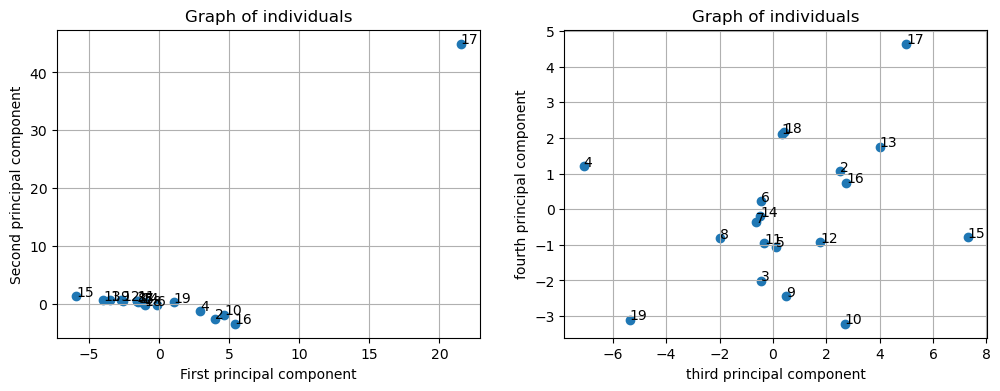

In [ ]:
plt.figure(figsize=(12, 4))
# construction of the first graph
plt.subplot(1, 2, 1)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 0], x_pca[i, 1]))
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Graph of individuals")
plt.grid(True)

# construction of the second graph
plt.subplot(1, 2, 2)
plt.scatter(x_pca[:, 2], x_pca[:, 3])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 2], x_pca[i, 3]))
plt.xlabel("third principal component")
plt.ylabel("fourth principal component")
plt.title("Graph of individuals")
plt.grid(True)

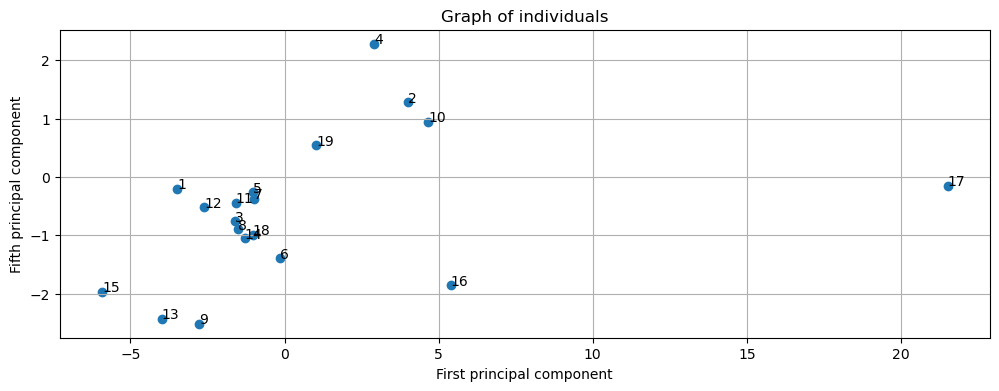

In [ ]:
#construction of the third graph 
plt.figure(figsize=(12, 4))
plt.scatter(x_pca[:, 0], x_pca[:, 4])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 0], x_pca[i, 4]))
plt.xlabel("First principal component")
plt.ylabel("Fifth principal component")
plt.title("Graph of individuals")
plt.grid(True)

Considérons l'individu numéro 17. Il a un coefficient élevé sur les deux premiers axes factoriels, ce qui signifie qu'il fait un grand nombre d'activités par thématique d'apprentissage et à de bons scores aux différentes session d'évaluation. De plus il a un coefficient négatif relativement faible sur le reste des axes factoriels, ce qui signifie qu'il a des scores peu dispersé autour de la moyenne, il a de bonne performance académique et est plus ou moins régulier aux sessions d'apprentissage. En bref, c'est un bon élève.

Par contre, l'individu numéro 15 a un coefficient négatif sur le premier axe factoriel, proche de 0 sur le deuxième axe factoriel et négatif sur le troisième axe factoriel ce qui signifie qu'il ne fait relativement peu d'activités par thématique d'apprentissage et n'a pas de bonnes performances académique. De plus, il a un coefficient négatif sur le cinquième axe factoriel et proche de 0 sur le quatrième et sixième axe factoriel, ce qui traduit le fait qu'il est moin régulier aux examens et ses sessions d'apprentissage sont moins concentrées.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Erreur de reconstruction
</p>
<br/>

In [19]:
from sklearn.metrics import mean_squared_error
# reconstruction of the data with inverse_transform
X_reconstructed = pca.inverse_transform(X_pca)

# Calculer l'erreur de reconstruction (norme Euclidienne)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)

In [20]:
print(f"Erreur de reconstruction : {reconstruction_error}")

Erreur de reconstruction : 0.543519029771535


In [27]:
# Calcul de l'information mutuelle entre les données originales et reconstruites
mi_scores = [mutual_info_regression(X_scaled[:, i].reshape(-1, 1), X_reconstructed[:, i]) for i in range(X_scaled.shape[1])]
#mean_mi = np.mean([np.mean(score) for score in mi_scores])
#print(f"Information mutuelle moyenne : {mean_mi:.4f}")
total_mi = np.sum(mi_scores)
print(f"Information mutuelle totale : {total_mi:.4f}")

Information mutuelle totale : 30.0488


In [29]:
from scipy.stats import entropy
def normalized_mutual_information(X_scaled, X_reconstructed):
    H_X = np.sum([entropy(np.histogram(X_scaled[:, i], bins=20)[0] + 1e-10) for i in range(X_scaled.shape[1])])  # Entropie totale
    I_X_Xhat = total_mi # Info mutuelle
    return I_X_Xhat / H_X  # Ratio d'info conservée

# Calcul du taux d'information mutuelle conservée
nmi = normalized_mutual_information(X_scaled, X_reconstructed)
print(f"Part d'information conservée (normalisée) : {nmi:.2%}")

Part d'information conservée (normalisée) : 31.77%


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
2- Analyse Factorielle des Composantes Mixtes (FAMD) </u>
</p>
<br/>

<p>
Nous avons réalisés 5 FAMD sur les données(en R), puis nous avons exporté différents resultats intéressant(variance expliquée, individu, variables).
</p>

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le chemin où sont stockés les fichiers exportés depuis R
export_path = r"C:/Users/damso/Documents/Projet_Statistique/"

# Liste des fichiers à importer
famd_versions = ["famd0","famd1", "famd2", "famd3", "famd_final"]

# Dictionnaires pour stocker les dataframes importés
coord_ind_total = {}
coord_var_total = {}
variance_total = {}

# Boucle pour importer les fichiers CSV dans des dictionnaires
for famd in famd_versions:
    coord_ind_total[famd] = pd.read_csv(os.path.join(export_path, f"{famd}_coord_ind.csv"), index_col=0)
    coord_var_total[famd] = pd.read_csv(os.path.join(export_path, f"{famd}_coord_var.csv"), index_col=0)
    variance_total[famd] = pd.read_csv(os.path.join(export_path, f"{famd}_variance.csv"), index_col=0)

# Affichage des informations importantes

print(f"\n==== Résultats pour famd0 ====")
print(f"Nombre d'individus: {coord_ind_total["famd0"].shape[0]}")
print(f"Nombre de variables: {coord_var_total["famd0"].shape[0]}")
print(f"Nombre de composantes: {variance_total["famd0"].shape[0]}")
print("Pourcentage de variance expliquée par chaque composante:\n", variance_total["famd0"].iloc[:, 1])



==== Résultats pour famd0 ====
Nombre d'individus: 200000
Nombre de variables: 371
Nombre de composantes: 30
Pourcentage de variance expliquée par chaque composante:
 comp 1     20.413033
comp 2      2.524357
comp 3      2.003599
comp 4      1.746728
comp 5      1.533339
comp 6      1.007631
comp 7      0.913385
comp 8      0.868160
comp 9      0.845962
comp 10     0.837021
comp 11     0.826354
comp 12     0.809997
comp 13     0.799562
comp 14     0.781710
comp 15     0.775136
comp 16     0.744219
comp 17     0.728571
comp 18     0.716312
comp 19     0.713825
comp 20     0.699645
comp 21     0.698554
comp 22     0.678189
comp 23     0.676258
comp 24     0.666379
comp 25     0.651333
comp 26     0.639637
comp 27     0.626626
comp 28     0.619195
comp 29     0.613205
comp 30     0.604893
Name: percentage of variance, dtype: float64


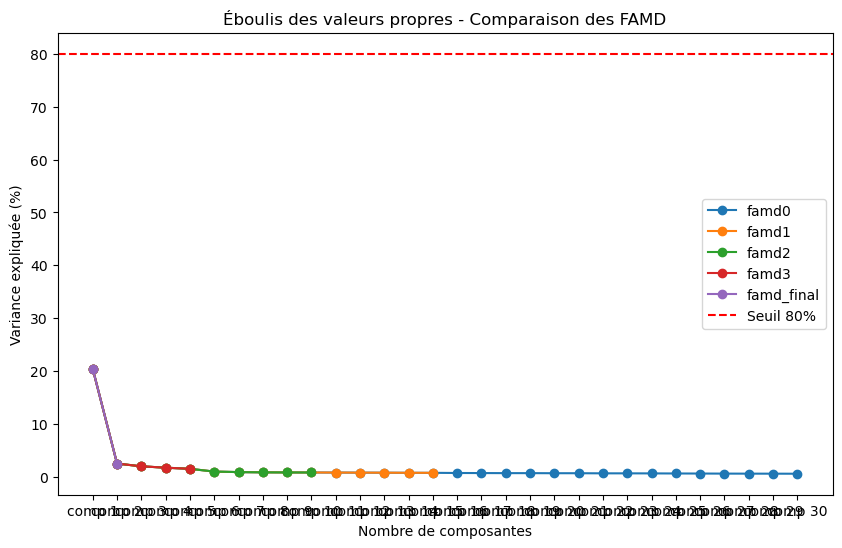

In [3]:
plt.figure(figsize=(10, 6))
for famd in famd_versions:
    plt.plot(variance_total[famd].index, variance_total[famd].iloc[:, 1], marker='o', label=famd)

plt.axhline(y=80, color='r', linestyle='--', label="Seuil 80%")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée (%)")
plt.title("Éboulis des valeurs propres - Comparaison des FAMD")
plt.legend()
plt.show()


## Distribution des individus dans les deux premières dimensions pour chaque cas

Composante 1 et 2

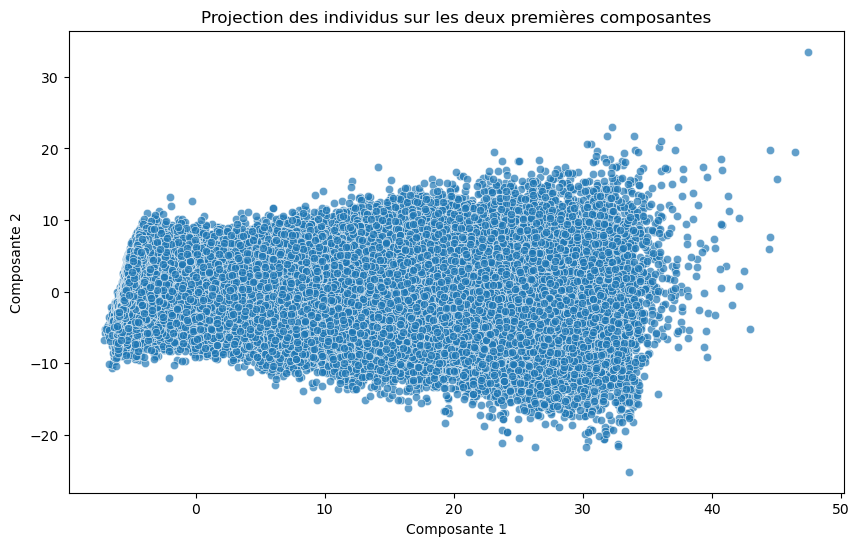

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total["famd0"].iloc[:, 0], 
                y=coord_ind_total["famd0"].iloc[:, 1], 
                alpha=0.7)
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()

Composantes 2 et 3

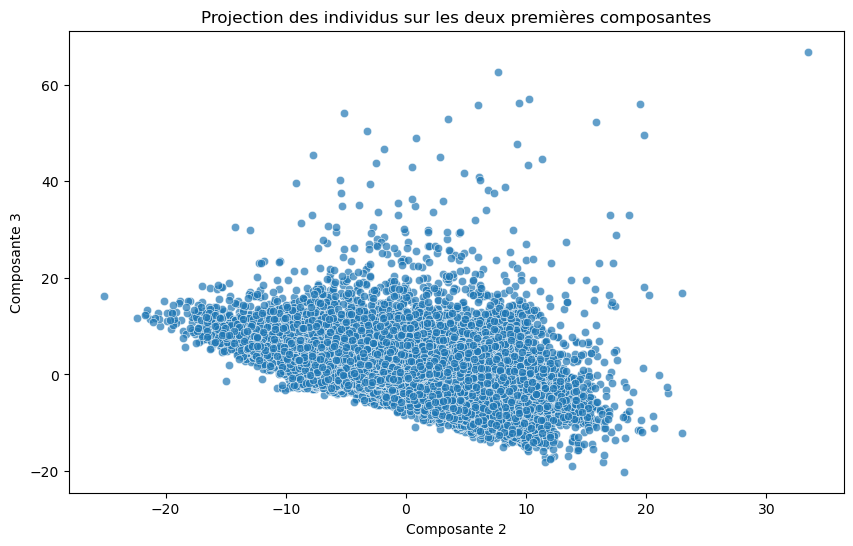

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total["famd0"].iloc[:, 1], 
                y=coord_ind_total["famd0"].iloc[:, 2], 
                alpha=0.7)
plt.xlabel("Composante 2")
plt.ylabel("Composante 3")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()

composantes 3 et 4

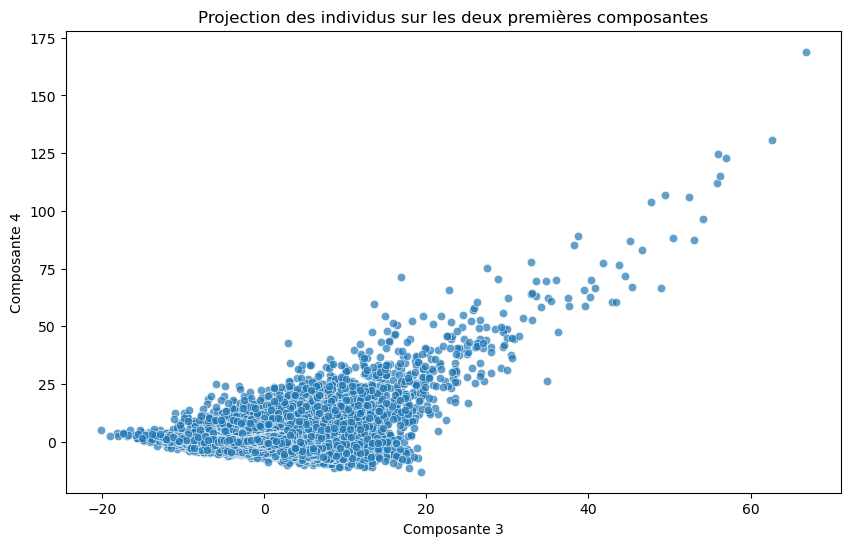

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total["famd2"].iloc[:, 2], 
                y=coord_ind_total["famd2"].iloc[:, 3], 
                alpha=0.7)
plt.xlabel("Composante 3")
plt.ylabel("Composante 4")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()

composantes 4 et 5

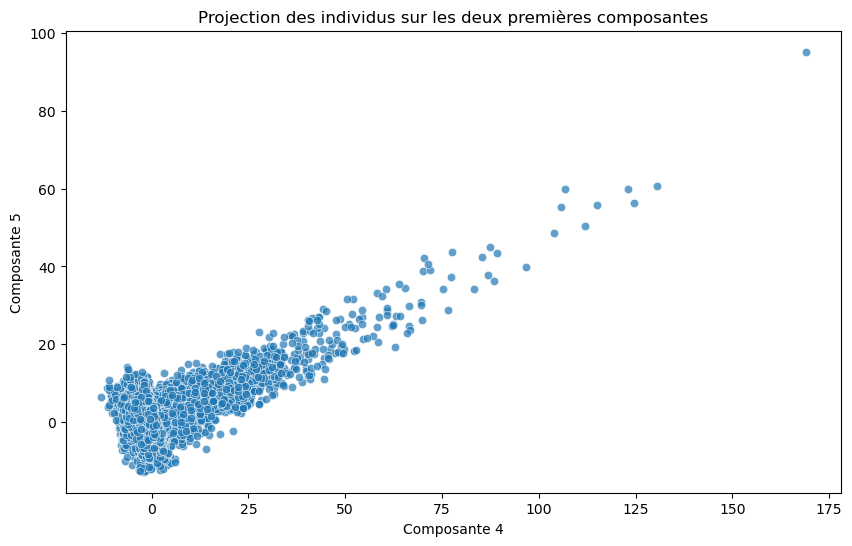

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total["famd0"].iloc[:, 3], 
                y=coord_ind_total["famd0"].iloc[:, 4], 
                alpha=0.7)
plt.xlabel("Composante 4")
plt.ylabel("Composante 5")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()

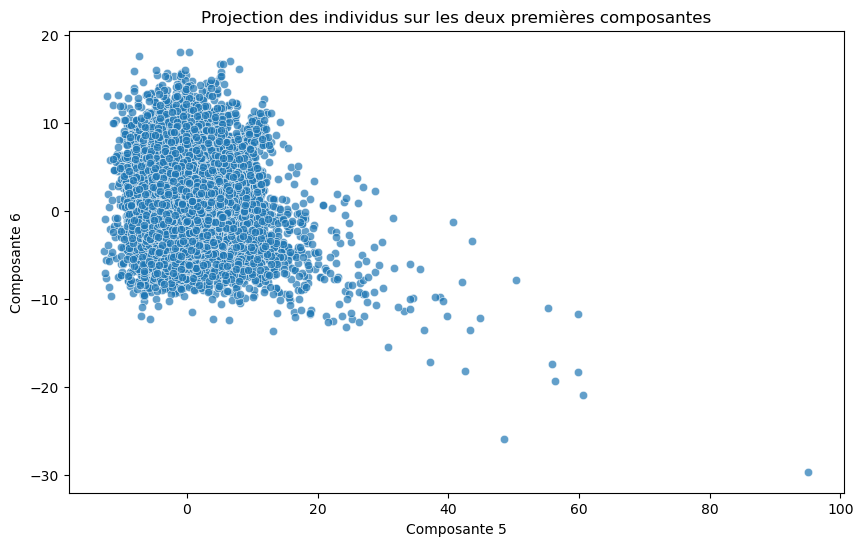

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total["famd0"].iloc[:, 4], 
                y=coord_ind_total["famd0"].iloc[:, 5], 
                alpha=0.7)
plt.xlabel("Composante 5")
plt.ylabel("Composante 6")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()


<br/>
L'évolution des distributions obtenue par la réduction des dimensions via la FAMD (Factorial Analysis of Mixed Data) peut être interprétée à travers plusieurs aspects clés :

### 1. **Projection des individus**
Les graphiques montrent la projection d'individus sur les premières composantes principales, ce qui permet de visualiser la structure sous-jacente des données. Chaque point représente un individu, et leur disposition dans le plan révèle des tendances et des regroupements.

### 2. **Dispersion des points**
- **Premier graphique :** Les points sont relativement dispersés, indiquant une diversité dans les données. La forme globale peut suggérer des groupes potentiels.
- **Deuxième graphique :** La concentration des points reste similaire, mais on peut observer une légère tendance à une distribution plus linéaire.
- **Troisième graphique :** Une tendance plus marquée apparaît, avec une augmentation des points dans une direction particulière, indiquant potentiellement un gradient ou une corrélation entre certaines variables.
- **Quatrième graphique :** La projection montre une distribution similaire, mais sur un autre axe, ce qui pourrait signaler des relations entre différentes dimensions.
- **Cinquième graphique :** La concentration des points dans cette projection suggère qu'il y a des variables qui partagent une relation commune.

### 3. **Interprétation des axes**
Les axes des graphiques (composantes 1, 2, 3, etc.) représentent des combinaisons linéaires des variables originales. L'interprétation de ces axes dépend des variables qui les composent. Une analyse plus approfondie des contributions des variables aux composantes peut révéler quelles variables sont les plus influentes dans la formation de ces groupes.

### 4. **Observations globales**
- **Tendances linéaires :** L'apparition de tendances linéaires dans plusieurs graphiques peut indiquer des relations corrélatives parmi certaines variables.

En résumé, cette série de graphiques permet de visualiser la structure des données après réduction de dimensions, mettant en lumière des tendances et des relations potentielles parmi les individus observés. 
<br/>
<br/>


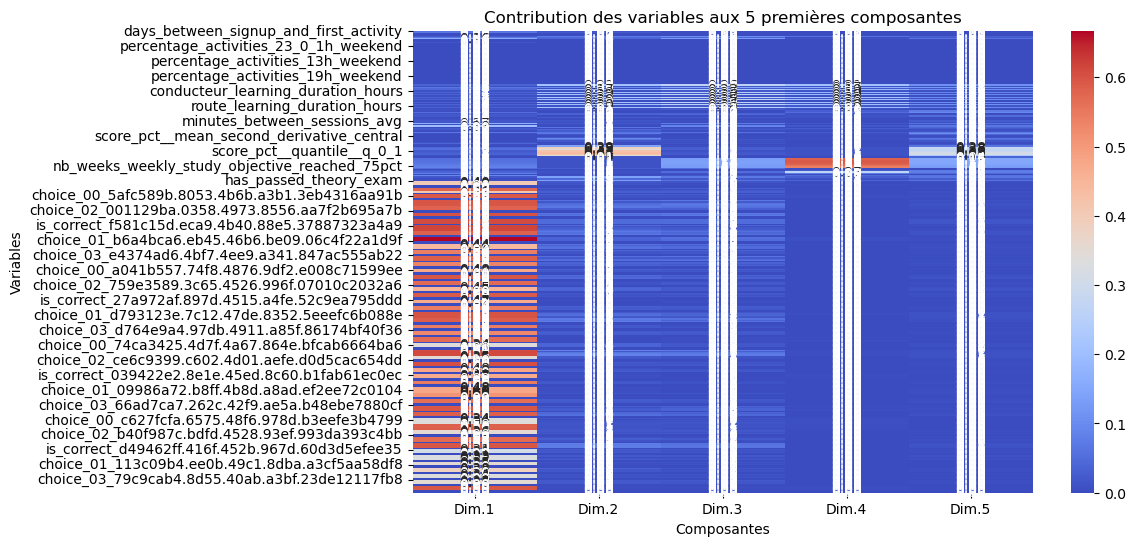

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(coord_var_total["famd0"].iloc[:, :5], cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Contribution des variables aux 5 premières composantes")
plt.xlabel("Composantes")
plt.ylabel("Variables")
plt.show()


Le graphique que vous avez partagé semble représenter la contribution des variables aux cinq premières composantes principales résultant d'une analyse FAMD. Voici une interprétation détaillée :

### 1. **Structure du graphique**
- **Axes :** L'axe des abscisses représente les cinq premières composantes (Dim 1 à Dim 5), tandis que l'axe des ordonnées liste les différentes variables analysées.
- **Coloration :** Les couleurs (typiquement des nuances de bleu et de rouge) indiquent l'ampleur de la contribution des variables à chaque composante. Généralement, les couleurs plus foncées ou plus saturées signalent une contribution plus importante.

### 2. **Interprétation des contributions**
- **Variables significatives :** Les variables qui montrent une couleur plus intense (bleu foncé, par exemple) pour une composante donnée sont celles qui contribuent le plus à cette composante. Cela signifie qu'elles capturent une grande partie de la variance expliquée par cette composante.
- **Distribution des contributions :** En examinant chaque composante, vous pouvez identifier quelles variables ont un impact positif ou négatif. Par exemple, si une variable a une forte contribution positive sur Dim 1, elle influence fortement cette dimension dans le sens positif.

### 3. **Identification des tendances**
- **Composantes principales :** Les premières composantes (Dim 1 et Dim 2) sont souvent les plus importantes, car elles capturent la majorité de la variance. Si certaines variables sont fortement associées à ces dimensions, elles méritent une attention particulière dans l'analyse.
- **Variabilité entre dimensions :** En observant les contributions à travers plusieurs dimensions, on peut voir si certaines variables sont constantes dans leur influence ou si elles changent significativement d'une dimension à l'autre.

### 4. **Implications pour l'analyse**
- **Focus sur les variables clés :** Les variables qui contribuent le plus aux premières composantes peuvent être des cibles prioritaires pour des analyses plus approfondies, des visualisations ou des décisions stratégiques.
- **Exploration de corrélations :** Certaines variables peuvent montrer des contributions opposées sur différentes dimensions, ce qui peut indiquer des relations complexes entre elles.


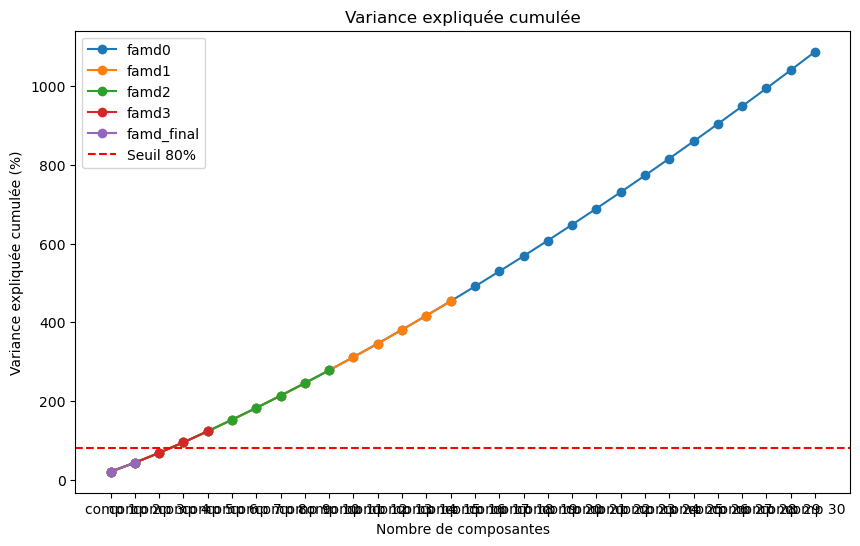

In [6]:
plt.figure(figsize=(10, 6))
for famd in famd_versions:
    plt.plot(variance_total[famd].index, variance_total[famd].iloc[:, 2].cumsum(), marker='o', label=famd)

plt.axhline(y=80, color='r', linestyle='--', label="Seuil 80%")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée (%)")
plt.title("Variance expliquée cumulée")
plt.legend()
plt.show()


Plus le nombre de dimension est elevé, plus  la variance cumulée expliquée est élevé.

Le graphique que vous avez partagé représente la variance expliquée cumulée par les différentes composantes principales résultant d'une analyse FAMD. Voici une interprétation détaillée :

### 1. **Structure du graphique**
- **Axes :** L'axe des abscisses représente le nombre de composantes, tandis que l'axe des ordonnées indique la variance expliquée cumulée (en pourcentage).
- **Curves colorées :** Chaque courbe représente une série de données (fam0, fam1, fam2, fam3, fam_final), montrant comment la variance expliquée évolue avec l'ajout de chaque composante.

### 2. **Interprétation de la variance expliquée**
- **Variance expliquée cumulée :** Le graphique montre comment la somme des variances expliquées augmente avec le nombre de composantes. Une courbe qui s'élève rapidement au début indique que les premières composantes capturent une grande partie de la variance.
- **Seuil de variance :** La ligne rouge (seuil) peut représenter un niveau minimal de variance que l'on souhaite atteindre pour retenir un nombre optimal de composantes. Par exemple, si ce seuil est fixé à 70%, on peut déterminer combien de composantes sont nécessaires pour atteindre ce niveau.

### 3. **Tendances observées**
- **Comportement des courbes :** Si certaines courbes atteignent le seuil de variance plus tôt que d'autres, cela indique que les variables associées à ces courbes sont plus efficaces pour expliquer la variance dans le jeu de données.
- **Équilibre entre complexité et performance :** Si une courbe montre une pente plus douce après un certain nombre de composantes, cela peut suggérer qu'ajouter d'autres composantes n'apporte qu'un faible gain en termes de variance expliquée.



<h2>
Informations sur les dimensions(composantes) conservées
</h2>

In [25]:
variance_total["famd0"]

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,92.062778,20.413033,20.413033
comp 2,11.384850,2.524357,22.937390
comp 3,9.036232,2.003599,24.940989
comp 4,7.877744,1.746728,26.687717
comp 5,6.915358,1.533339,28.221056
comp 6,4.544415,1.007631,29.228686
comp 7,4.119365,0.913385,30.142071
comp 8,3.915400,0.868160,31.010231
comp 9,3.815290,0.845962,31.856193
comp 10,3.774965,0.837021,32.693214


 <b> les deux premières  dimensions, qui contiennent des informations sur 372 variables(de "days_between_signup_and_first_activity" à "unique_learner_id") et expliquent  22,93% environ de la variance totale. à partir de 7 composantes nous avons 30% de variance expliquée</b>

[20.41303277  2.52435693  2.00359905  1.74672813  1.5333388   1.00763073
  0.91338463  0.86815964  0.84596238  0.83702106  0.82635435  0.80999738
  0.79956242  0.78171026  0.77513592  0.74421931  0.72857128  0.71631246
  0.71382505  0.69964476  0.69855368  0.67818902  0.67625774  0.66637854
  0.65133271  0.63963715  0.62662602  0.61919498  0.61320504  0.60489292]
🔹 Nombre optimal de dimensions pour famd1 selon la méthode de Kaiser = 6


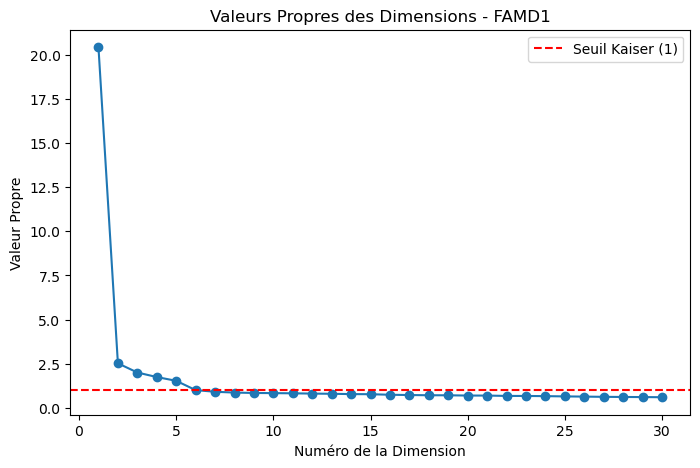

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Extraire les valeurs propres de famd1 (première colonne)
eigenvalues = np.array(variance_total["famd0"].iloc[:, 1])  # Prend bien la variance brute
print(eigenvalues)
# Méthode de Kaiser : garder les composantes avec variance > 1
optimal_dimensions = np.sum(eigenvalues > 1)

print(f"🔹 Nombre optimal de dimensions pour famd1 selon la méthode de Kaiser = {optimal_dimensions}")

# Tracer les valeurs propres
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--', label='Seuil Kaiser (1)')
plt.title("Valeurs Propres des Dimensions - FAMD1")
plt.xlabel("Numéro de la Dimension")
plt.ylabel("Valeur Propre")
plt.legend()
plt.show()


<h2> La méthode de Kaiser nous suggère via ce graphique de ne conserver que les 6 premières 1<sup>ere</sup> composantes
</h2>

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Auto Encoder </u>
</p>
<br/>

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de 30000 observations pour notre Auto-Encoder. 

In [ ]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

Le calibrage des hyperparamètres tels que le nombre de couche, les fonctions d'activations, le type de normalisation est détaillé dans l'annexe du fichier AutoEncoder. Ont été retenus les hyperparamètre suivant : 
* Type de normalisation : MinMax
* Nombre de couche : Une couche caché en encdeur et au niveau du décodeur
* Fonctions d'activation : **Linear** dans les couches de l'encodeur et **sigmoid** en décodeur 

Nous nous concentrerons donc maintenant sure le choix de la dimension latente. 

### Choix du Nombre Optimal de Dimensions Latentes pour un Autoencodeur : Une Analyse Basée sur l’Information Mutuelle
Dans le cadre de la réduction de dimension à l’aide d’un autoencodeur, l’un des défis majeurs consiste à choisir un nombre optimal de dimensions latentes permettant d’atteindre un compromis entre compacité de la représentation et préservation de l’information essentielle. Pour guider ce choix, nous nous appuyons sur une mesure clé : l’information mutuelle.

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux ensembles de variables. Plus précisément, dans notre contexte, elle permet d’évaluer dans quelle mesure les variables latentes conservent l’information contenue dans les variables d’origine. Formellement, l’information mutuelle entre deux variables aléatoires $(X)$ et $(Z)$ est donnée par :


$I(X,Z) = \sum_{x \in X} \sum_{z \in Z} P(x, z) \log \frac{P(x, z)}{P(x) P(z)}$

où $(P(x, z))$ est la distribution conjointe de $(X)$ et $(Z)$, et $(P(x))$, $(P(z))$ sont leurs distributions marginales respectives.

Dans le contexte d’un autoencodeur, cette mesure nous permet de quantifier la capacité des dimensions latentes à encoder efficacement l’information contenue dans les données initiales. Une information mutuelle élevée signifie que la représentation latente conserve beaucoup d’information sur les données originales, tandis qu’une information mutuelle faible suggère une perte d’information plus importante.


657/657 [==============================] - 2s 3ms/step


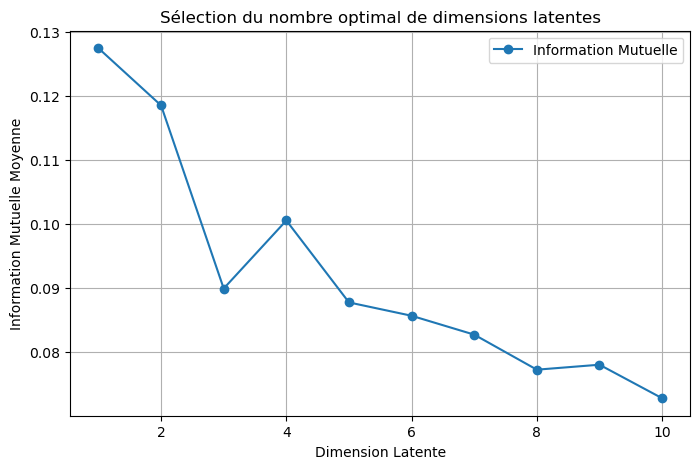

In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

final_data = np.hstack([encoded_cats, scaled_nums])
final_columns = list(encoded_cat_columns) + list(numerical_cols)

x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)
input_dim = x_train.shape[1]
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# === 3. Tester différentes dimensions latentes et calculer l'information mutuelle ===
mutual_info_scores = []
latent_dims = range(1, 11)

for encoding_dim in latent_dims:
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)
    Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    encoder_model = Model(input_img, encoded)
    encoded_imgs = encoder_model.predict(x_train)
    
    mi_scores = np.array([
        np.mean([mutual_info_regression(x_train[:, j].reshape(-1, 1), encoded_imgs[:, i]) 
                 for j in range(x_train.shape[1])])
        for i in range(encoding_dim)
    ])
    
    mutual_info_scores.append(np.mean(mi_scores))

# === 4. Tracer la courbe de l'information mutuelle ===
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mutual_info_scores, marker='o', linestyle='-', label="Information Mutuelle")
plt.xlabel("Dimension Latente")
plt.ylabel("Information Mutuelle Moyenne")
plt.title("Sélection du nombre optimal de dimensions latentes")
plt.legend()
plt.grid()
plt.show()


L’analyse de la courbe obtenue montre une tendance générale décroissante de l’information mutuelle lorsque le nombre de dimensions latentes augmente. Cela est attendu, car en réduisant la dimensionnalité, nous éliminons progressivement certaines redondances mais aussi, potentiellement, des informations pertinentes.

Cependant, une observation plus fine révèle que :

* Entre 1 et 5 dimensions, l’information mutuelle diminue de manière marquée mais non linéaire.
* À partir de 5 dimensions, la décroissance devient plus progressive et régulière.
* L’ajout de dimensions au-delà de 5 n’apporte qu’un gain marginal en information mutuelle, suggérant que l’information restante est soit moins pertinente, soit redondante.

Nous choissons donc la valeur 5 pour la dimension de l'espace latent. 

Ce choix garantit un équilibre optimal entre compression et préservation d’information, permettant ainsi d’assurer une représentation efficace et compacte des données tout en évitant des dimensions inutiles.

L’étape suivante consiste à valider ce choix à l’aide de l’erreur de reconstruction, pour s’assurer que l’information capturée par ces 5 dimensions latentes est suffisante pour une bonne qualité de reconstruction des données originales.

In [2]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 5

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# Encodeur
Hidden1 = Dense(350, activation='linear', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


NameError: name 'base_AE' is not defined

Nous obtenons une erreur de reconstruction égale à 0.0328. Ce qui indique que l'autoencodeur parvient à reconstruire les données d'origine avec une précision raisonnable. Nous maintenons donc 5 comme dimension de l'espace latent. 

Aussi Le graphique précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=5 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=5 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

Nous allons maintenant passer à l'interprétation des nos 5 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. Ce effet sera utiliser pour déterminer quelles variables de départ influencent le plus quelle variable latente 

In [ ]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test)  # Analyser un sous-échantillon de test

In [ ]:
# # Vérification de la structure des valeurs SHAP
# print(f"Shape of shap_values: {len(shap_values)} dimensions latentes.")
# print(f"Shape of shap_values for first latent variable: {shap_values[0].shape}")
# print(f"Shape of x_test: {x_test.shape}")
# print(np.shape(shap_values))

In [ ]:
import pandas as pd

# Pour chaque dimension latente
for i in range(5):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(10))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              4.033124
is_first_exam_success_2                              2.977121
pct_no_objective_weeks                               2.670113
pct_study_objective_not_reached                      2.494268
choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.286206
choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     2.266252
prendre_quitter_vehicule_number_of_activities        1.855797
has_passed_theory_exam_1                             1.825285
autres_usagers_number_of_activities                  1.779124
is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1    1.730351
dtype: float64
Les variables les plus influentes pour la 2-ème dimension latente:
choice_02_d793123e-7c12-47de-8352-5eeefc6b088e_0     3.502550
is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0    3.447411
choice_03_d793123e-7c12-47de-8352-5eeefc6b088e_0     3.391110
is_first_exam_success_1                      

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes. Mais cette sortie serait plus intéressante sous forme de graphique.

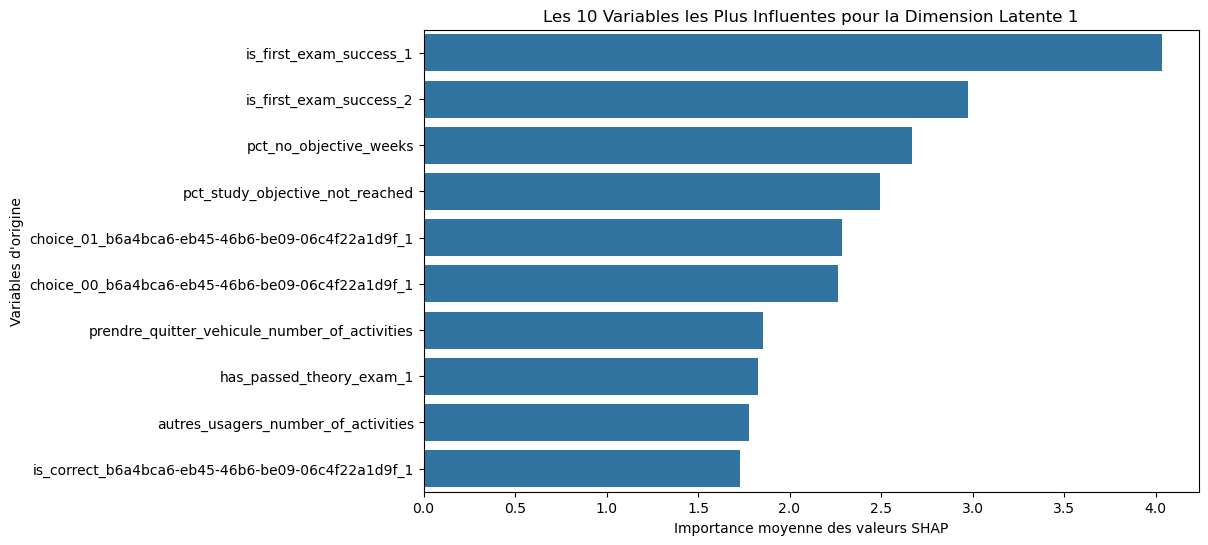

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=0 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension reflète la **préparation du candidat** et ses **performances initiales** dans le cadre de l'examen de permis. Les variables clés sont :

* **Réussite au premier examen** (is_first_exam_success_1, is_first_exam_success_2) : Indique si le candidat a réussi son premier examen.  
* **Manque d'objectifs d’étude** (pct_no_objective_weeks) : Montre si le candidat n'a pas d'objectifs clairs pendant sa préparation.  
* **Objectifs d’étude non atteints** (pct_study_objective_not_reached) : Mesure les objectifs d’étude non réalisés.  
* **Réponses aux questions d'examen** (choice_01_..., choice_00_...) : Indique les réponses correctes ou incorrectes aux questions.  
* **Activités pratiques de conduite** (prendre_quitter_vehicule_number_of_activities) : Nombre d'activités pratiques réalisées.  
* **Réussite à l'examen théorique** (has_passed_theory_exam_1) : Indique si le candidat a réussi l'examen théorique.  
* **Interactions avec d'autres usagers** (autres_usagers_number_of_activities) : Mesure l'expérience avec d'autres conducteurs.

La dimension évalue **la préparation et la réussite initiale** du candidat, en tenant compte de ses performances théoriques et pratiques, ainsi que de son engagement dans la préparation.


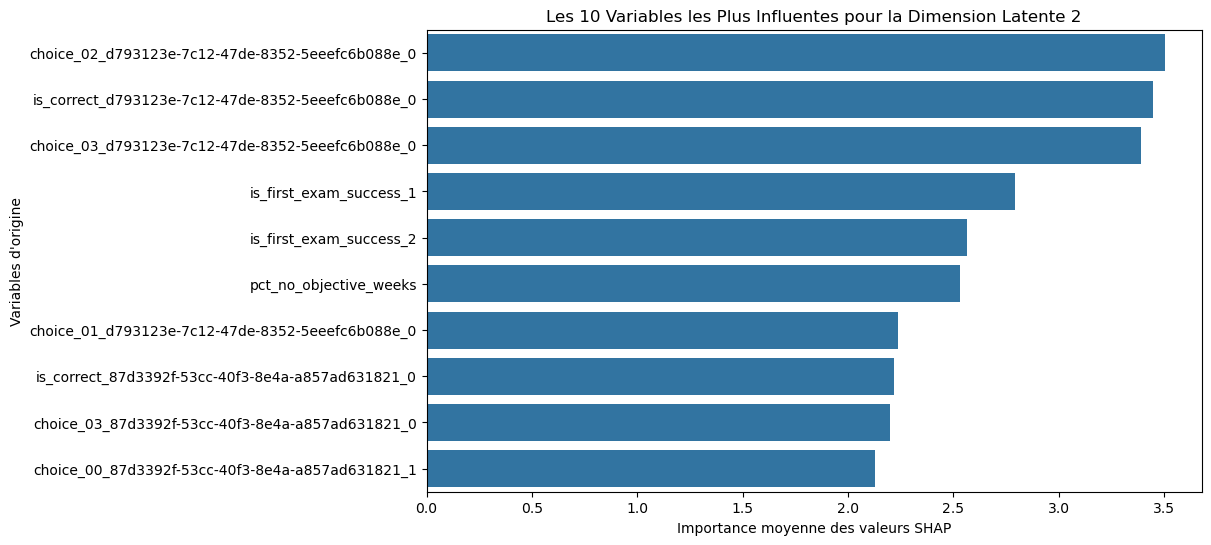

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=1 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble évaluer la **compréhension théorique** du candidat ainsi que sa **réaction aux questions spécifiques** du test. Les variables les plus influentes sont :

* **Réponses incorrectes aux questions spécifiques** (choice_02_..., choice_03_...) : Ces variables montrent les mauvaises réponses données aux questions du test. Cela reflète des **difficultés théoriques** ou un manque de préparation pour certains types de questions.
* **Exactitude des réponses spécifiques** (is_correct_...) : Indique si les réponses aux questions spécifiques étaient correctes ou non, ce qui montre l’**exactitude** du candidat dans la compréhension théorique.
* **Réussite au premier examen** (is_first_exam_success_1, is_first_exam_success_2) : Bien que déjà mentionnée, ici elle peut refléter la **compréhension théorique** du candidat, surtout par rapport à des erreurs spécifiques.


La **dimension latente 2** se concentre sur la **performance théorique** du candidat, en mettant en lumière ses **réponses correctes ou incorrectes** aux questions spécifiques du test et ses erreurs fréquentes, ce qui donne un aperçu de ses **difficultés théoriques**.


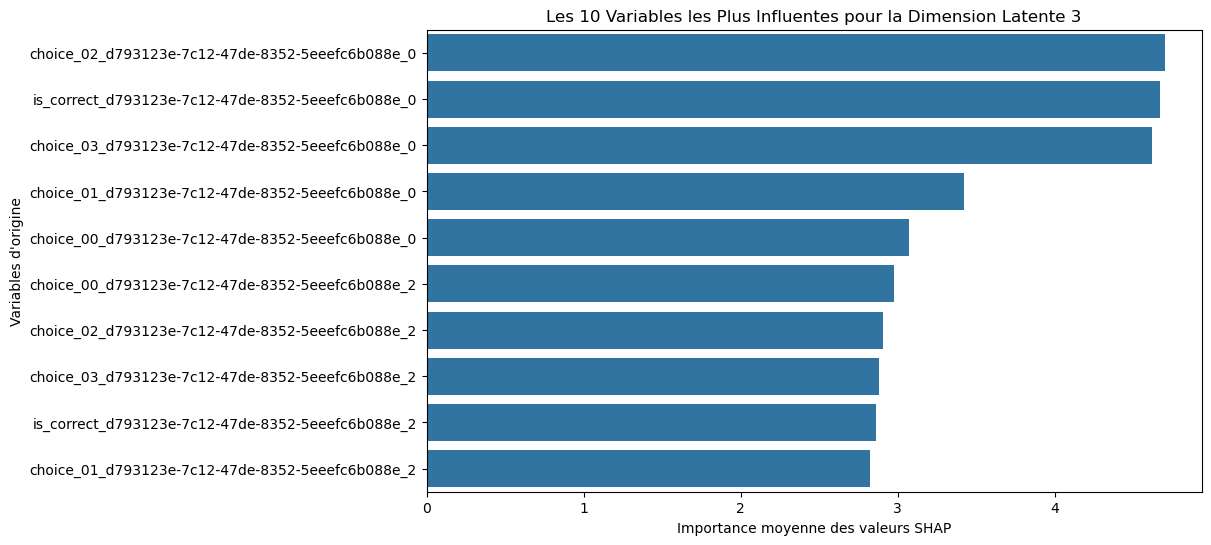

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=2 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble capturer la **sensibilité du candidat aux questions difficiles ou pièges** dans l'examen théorique.  Les variables clés sont :   
1. **Échecs aux mêmes questions spécifiques** (choice_02_..., choice_03_..., choice_01_..., is_correct_...) : Indique que certaines questions reviennent souvent parmi les erreurs du candidat.  
2. **Présence d’options "Non Renseigné"** (choice_00_..._2, choice_02_..._2, etc.) : Le candidat n’a peut-être pas répondu ou a hésité, suggérant une **incertitude face aux questions complexes**.  

La **dimension latente 3** reflète la **difficulté du candidat avec les questions théoriques complexes**, particulièrement celles qui induisent en erreur ou demandent une compréhension plus fine des règles. Cela peut indiquer un manque de confiance ou une hésitation face aux pièges du test.  


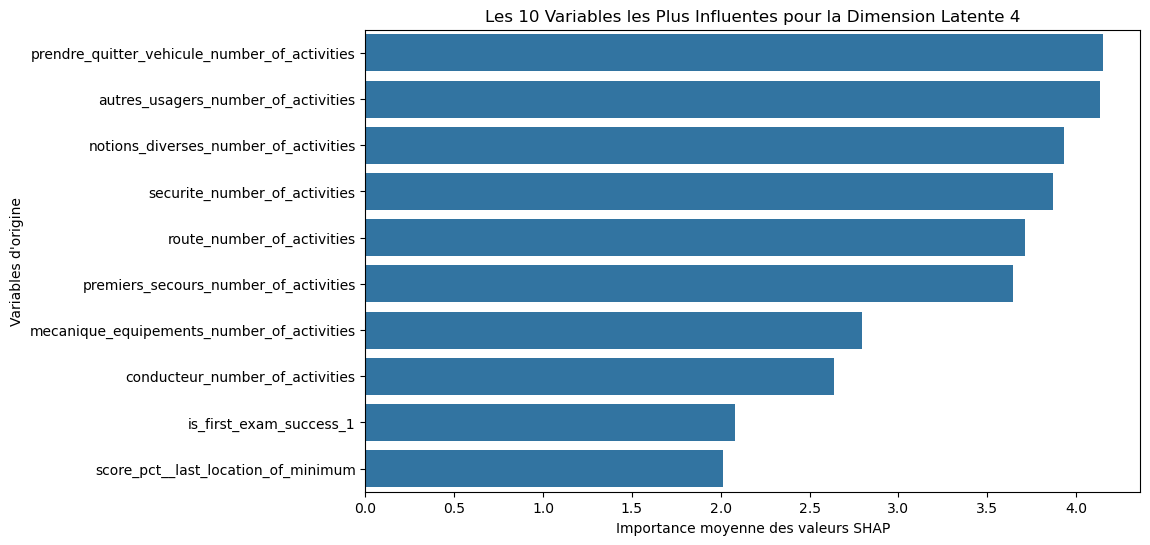

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=3 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()



Cette dimension semble refléter **l'implication du candidat dans les différentes catégories d’exercices pratiques**.  Les variables clés sont :  
1. **Nombre d’activités réalisées** (prendre_quitter_vehicule_number_of_activities, route_number_of_activities, securite_number_of_activities, etc.) : Indique le volume d’exercices effectués dans différents domaines.  
2. **Thèmes couverts** (mécanique, premiers secours, autres usagers, etc.) :  Montre si le candidat a exploré plusieurs aspects du code et de la conduite.  
3. **Succès au premier examen théorique** (is_first_exam_success_1) :  Une corrélation avec la réussite suggère que l'engagement pratique peut influencer les performances théoriques.  

La **dimension latente 4** représente **l’implication du candidat dans la formation pratique** et sa diversité d’exercices. Un score élevé ici pourrait indiquer un candidat **sérieux et appliqué** dans son apprentissage.  


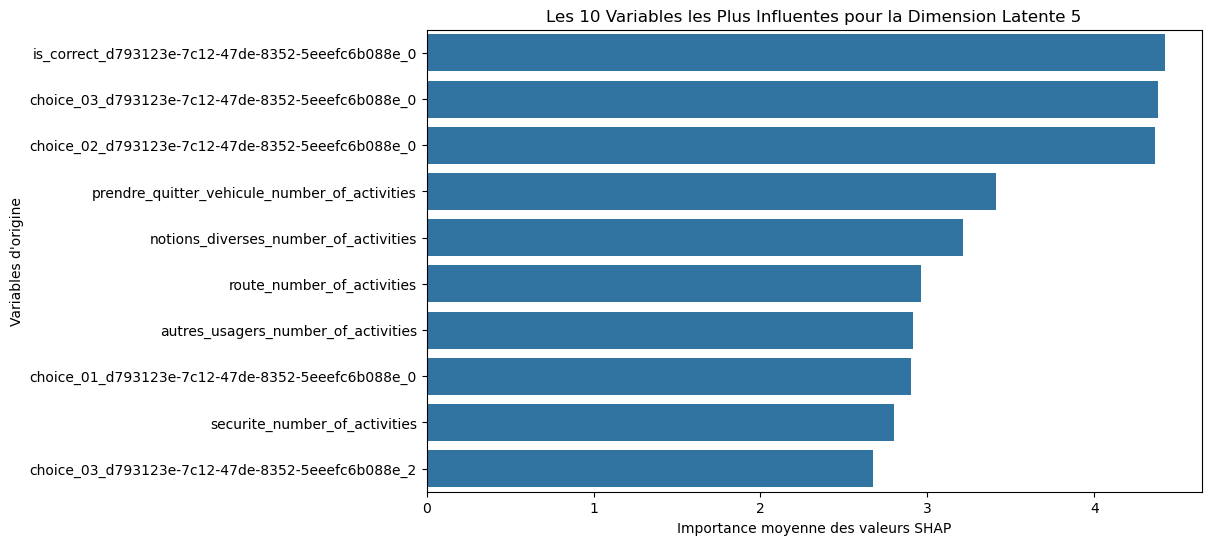

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=4 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette dimension semble réfléter la **Performance sur des Questions Spécifiques et Expérience Pratique**  

Les variables clés sont :  
1. **Réponses correctes sur des questions spécifiques** (is_correct_d793123e…, choice_03…, choice_02…) :  Indique si le candidat a bien répondu à certaines questions du test.  
2. **Nombre d’activités pratiques** (prendre_quitter_vehicule_number_of_activities, notions_diverses_number_of_activities, route_number_of_activities, etc.) :  Reflète l'expérience accumulée dans différents aspects de la conduite.  

Cette **dimension latente 5** semble capturer **la capacité à répondre correctement à des questions ciblées tout en ayant une certaine expérience pratique**. Un score élevé peut refléter un candidat **qui combine théorie et application**.  

